Foltányi Kolos

# Csődelőrejelzés Többáltozós Statisztikai Módszerekkel
A csődelőrejelzés alapvető célja csődvalószínűség, illetve fizetőképességet kifejező score becslése az egyes megfigyelésekhez a magyarázó változók (pénzügyi mutatók) és a csődeseményt kifejező bináris célváltozó felhasználásával.

## Csődmodell fejlesztés és értékelés
A modellfejlsztés során a csődmodellezési adatbázison a korábban megképzett 1/0 csődesemény célváltozó felhasználásával két statisztikai módszerrel készítünk csődelőrejelzési modellt. Az elkészített modelleket a ROC görbe és a klasszifikációs mátrix vizsgálatával értékeljük.

**1. Logisztikus regressziós modell készítése**<br>
**2. A Regressziós modell értékelése**<br>
**3. Döntési fa készítése**<br>
**3. A döntési fa értékelése**

A modellek input változóiként az előző lépésben képzett főkomponenseket és a klaszterelemzés eredményeként előállt kategóriaváltozót használjuk fel. Ezeket az adokat a `variable` változóba olvassuk be. A modellek tanításához szükségünk lesz továbbá a célváltozóra, amit az eredeti adatbázisból olvasunk be a `target` változóba.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


target = pd.read_excel('database.xlsx', index_col=0).loc[:,'CSOD']
variables = pd.read_excel('clustered.xlsx')

A `CLUSTER` kategóriaváltozó modellekben való használatához az egyes osztályokhoz dummy változókat kell létrehoznunk. Ez azt jelenti, hogy a 10 szintű kategóriaváltozónkat 10 db bináris változóvá alakítjuk, ahol az egyes oszlopok azt jelzik, hogy az adott kategóriába tartozik-e a rekord vagy sem (1/0).

In [3]:
names = [f'CLUSTER_{i+1}' for i in range(10)]

dummies = pd.get_dummies(variables['CLUSTER'], columns=names)

variables.drop(['CLUSTER'], axis=1, inplace=True)

for i, name in enumerate(names):
    variables[name] = dummies[i]

variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PCA_ESZK_JOVED         1000 non-null   float64
 1   PCA_BEV_ARANYOS_JOVED  1000 non-null   float64
 2   PCA_ELAD_MERTEKE       1000 non-null   float64
 3   PCA_TOKE_ELLAT         1000 non-null   float64
 4   PCA_LIKVID             1000 non-null   float64
 5   PCA_MERET              1000 non-null   float64
 6   PCA_FEDEZETTSEG        1000 non-null   float64
 7   CLUSTER_1              1000 non-null   uint8  
 8   CLUSTER_2              1000 non-null   uint8  
 9   CLUSTER_3              1000 non-null   uint8  
 10  CLUSTER_4              1000 non-null   uint8  
 11  CLUSTER_5              1000 non-null   uint8  
 12  CLUSTER_6              1000 non-null   uint8  
 13  CLUSTER_7              1000 non-null   uint8  
 14  CLUSTER_8              1000 non-null   uint8  
 15  CLUST

## 1. Logisztikus Regresszió
Először kialakítjuk a tanuló és teszt halmazokat a hozzájuk tartozó célváltozókkal együtt:

In [91]:
X_train, X_test, y_train, y_test = train_test_split(variables, target, test_size=0.3)

Ezután létrehozzuk a logisztikus regressziós modellt:

In [41]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train);

A regressziós modell együtthatói a következők lettek:

In [44]:
coefs = logreg.coef_[0]
pd.DataFrame(coefs, index=variables.columns, columns=[ 'COEF'])

,COEF
PCA_ESZK_JOVED,0.041804
PCA_BEV_ARANYOS_JOVED,-0.731400
PCA_ELAD_MERTEKE,0.241388
PCA_TOKE_ELLAT,-0.114717
PCA_LIKVID,-0.402002
PCA_MERET,0.287746
PCA_FEDEZETTSEG,0.052199
CLUSTER_1,0.018826
CLUSTER_2,0.238002
CLUSTER_3,-1.178728


Látható, hogy míg az eladósodottság mértéke főkomponens pozitív együtthatót kapott (0.241388) a likviditás negatívat (-0.402002). Ez pénzügyi-szakmai megfontolásból is helyénvaló, hiszen a csődesemény valószínűségét az eladósodottság mértéke növeli, az jó fizetőképességet indikáló mutatók pedig csökkentik.

## 2. A Regressziós modell értékelése

A teszthalmaz változóihoz kiszámoljuk a prediktált csődeseményt indikáló célváltozót:

In [27]:
y_pred = logreg.predict(X_test)

A modell értékeléséhez kiszámoljuk a pontosságot, melyet a sikeres becslések számának és az összes minta hányadosaként kapunk meg.

In [28]:
conf = confusion_matrix(y_test, y_pred)
TN = conf[0,0]
TP = conf[1,1]
print(f'Accuracy: {(TP + TN) / len(y_test)}')

Accuracy: 0.9133333333333333


Klasszifikációs mátrix:

In [40]:
pd.DataFrame(conf, columns = ["Actual True", "Actual False"], index = ["Predicted True", "Predicted False"])

,Actual True,Actual False
Predicted True,267,2
Predicted False,24,7


ROC görbe:

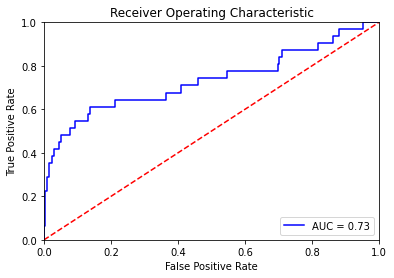

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

probs = logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Összességében a 0.73-as AUC érték megfelelőnek tekinthető. A másodfajú hibák számát azonban tovább lehetne csökkenteni a regressziós paraméterek finomhangolásával.

## 3. Döntési fa

A döntési fák a megfigyeléseket oly módon csoportosítják, hogy a csoportokon belüli variancia minél kisebb, míg a csoportok közötti variancia minél nagyobb legyen. A döntési fa a legerősebb particionáló erővel rendelkező változók mentén épül fel.

A túl kevés elemszámot tartalmazó szegmensek elkerülése érdekében a szülő- és gyerekágak képezhetőségét paraméterezni szükséges. Ezt a `min_samples_split`, `min_samples_leaf` paraméterek állításával tudjuk megtenni. A paraméterek értékeit rendre a tanulási halmaz 4%- és 1%-ra állítjuk.

In [92]:
min_split = int(len(X_train)*0.04)
min_leaf = int(len(X_train)*0.01)
print('min samples split: ', min_split)
print('min samples leaf: ', min_leaf)

min samples split:  28
min samples leaf:  7


A kiszámolt paraméterekkel létrehozzuk, majd a tanuló mintával felépítjük a döntési fát, melyenek mélységét maximum 5 szintre állítjuk:

In [93]:
dectree = DecisionTreeClassifier(max_depth=5, min_samples_split=min_split, min_samples_leaf=min_leaf)
dectree = dectree.fit(X_train, y_train)

Az így kapott döntési fát az alábbi módon tudjuk ábrázolni:

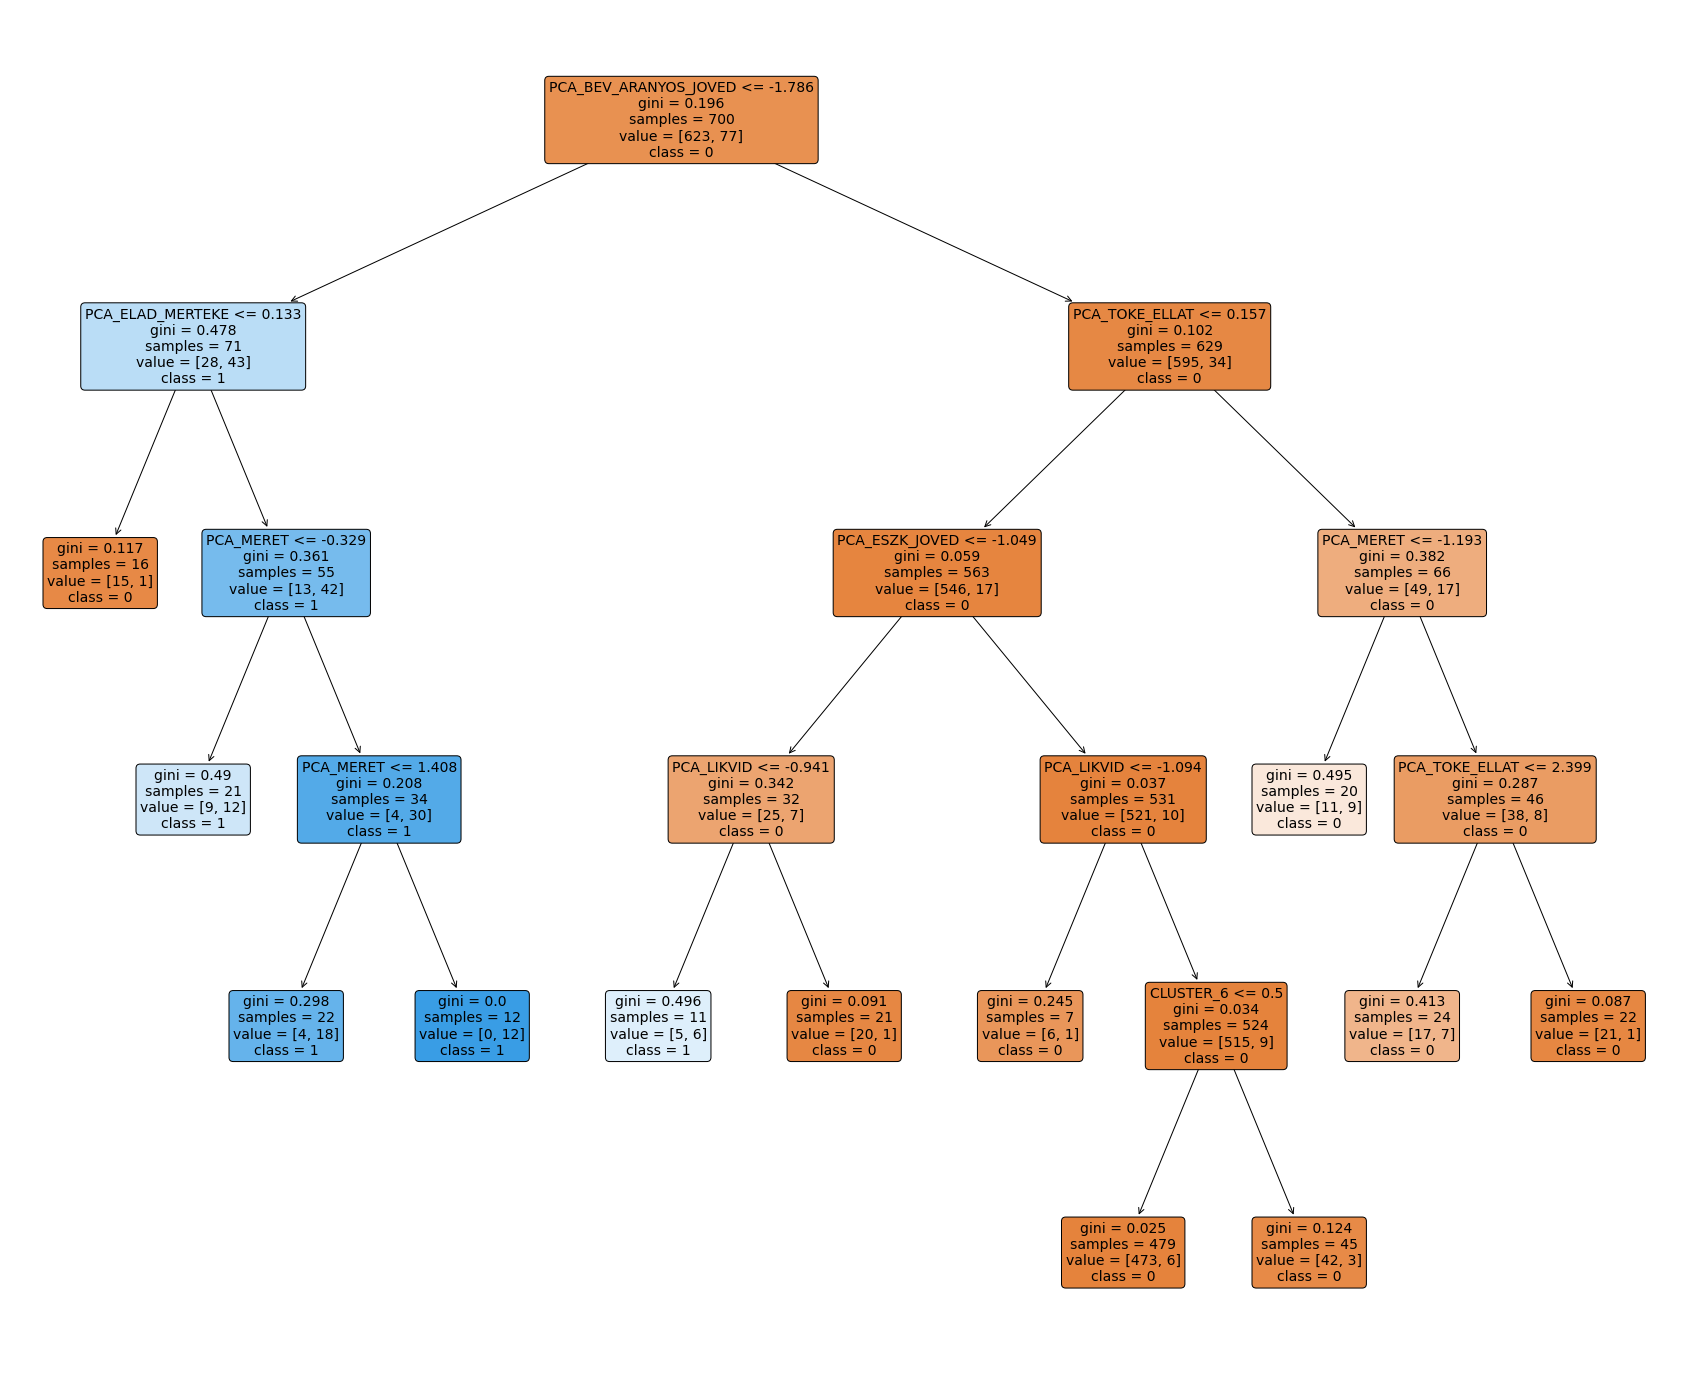

In [94]:
plt.figure(figsize=(30,25))
feature_cols = variables.columns.values
a = plot_tree(dectree, feature_names=feature_cols, class_names=['0','1'], filled=True, rounded=True, fontsize=14)

Nem meglepő módon a fa gyökere a bevétel arányos jövedelmezőségi főkomponens mentén ágazik el, mely a logisztikus regressziós modellünkben is szignifikáns változó volt.

## 4. A döntési fa értékelése

Az modell értékeléséhez, először a teszthalmaz változóin elvégezzük a predikciót a kapott fával:

In [95]:
y_pred = dectree.predict(X_test)

Majd ki tudjuk számolni a modellünk pontosságát:

In [99]:
conf = confusion_matrix(y_test, y_pred)
TN = conf[0,0]
TP = conf[1,1]
print(f'Accuracy: {(TP + TN) / len(y_test)}')

Accuracy: 0.8966666666666666


Klasszifikációs mátrix:

In [101]:
pd.DataFrame(conf, columns = ["Actual True", "Actual False"], index = ["Predicted True", "Predicted False"])

,Actual True,Actual False
Predicted True,258,19
Predicted False,12,11


ROC görbe:

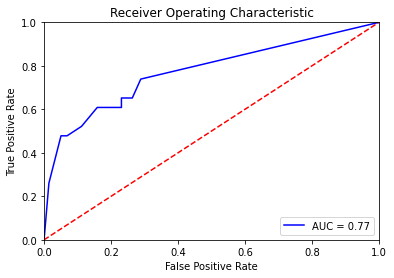

In [98]:
probs = dectree.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

A döntési fával a regressziós modelhez hasonló, annál valamilvel pontosabb eredményeket kaptunk. A fa pontosságát hasonlóan a regressziós modelhez, a képzési paraméterek hangolásával tovább lehetne javítani. A 0.77-es AUC érték azonban elfogadhatónak tekinthető.